### Assignment 02

Start by importing all required libraries.

In [1177]:
import cv2
import numpy as np

from scipy.optimize import minimize
from scipy import linalg

import matplotlib.pyplot as plt

#### Question 01

We start by importing the required image in grayscale.

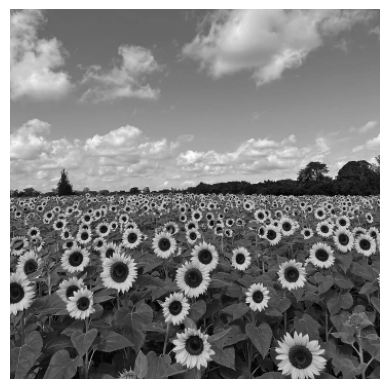

In [1178]:
im = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

We will look for blobs using a Laplacian of Gaussian (LoG) kernel.

A 2D (continuous) Gaussian with zero-mean and variance $\sigma^2$ is given by
$$
G(x, y) = \dfrac{1}{2\pi\sigma^2} \exp\left(-\dfrac{x^2+y^2}{2\sigma^2}\right),
$$
and its Laplacian is given by
$$
L(x, y) = \nabla^2 \, G(x, y) = \left[ \dfrac{x^2 + y^2 - 2\sigma^2}{2\pi\sigma^6}\right] \exp\left(-\dfrac{x^2+y^2}{2\sigma^2}\right).
$$

We now implement the LoG kernel.

In [1179]:
def LoG(sigma, k):
    '''
        Generate a k x k Laplacian of Gaussian kernel with standard deviation sigma.

        k is expected to be odd.
    '''
    
    k = (k - 1) // 2

    X, Y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))

    R2 = X**2 + Y**2

    log = ((R2 - 2*sigma**2) / (2*np.pi*sigma**6)) * np.exp(-R2 / (2*sigma**2))

    return log

Consider a (continuous) image of a perfect circle of radius $R$, given by
$$
I(x, y) =
\begin{cases}
1, & x^2 + y^2 < R^2, \\
0, & \text{otherwise}.
\end{cases}
$$

It is easy to see (due to radial symmetry) that the response of the LoG kernel to such an image is
$$
2\pi \int_0^R L(x, 0) \, dx,
$$
and that this response is maximum when 
$$
\dfrac{\text{d}}{\text{d}R} \int_0^R L(x, 0) \, dx = L(R, 0) = 0,
$$
which occurs precisely when
$$
R=\sigma\sqrt{2}.
$$

Hence, the kernel's maximum response for a circle occurs when it has radius $\sigma\sqrt{2}$; and so we conclude that a LoG kernel with parameter $\sigma$ acts to detect blobs of "radius" $\sigma\sqrt{2}$.

Below, we implement the code to run a LoG kernel over an image with some specified $\sigma$.

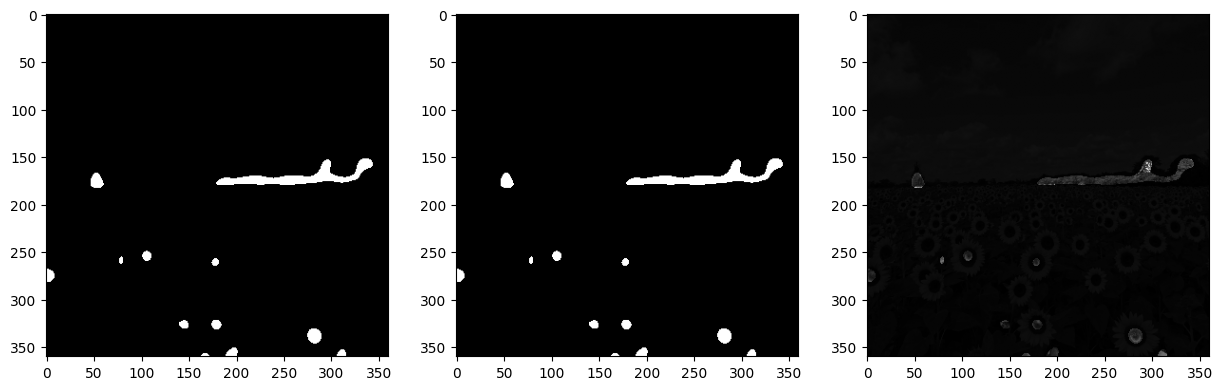

In [1180]:
def detect_blobs(im, sigma, size, thresh):
    '''
    docstring
    '''
    
    log = LoG(sigma, size)

    response = cv2.filter2D(im, -1, log)

    max = np.max(response)

    detected_blobs = response > 0.98*max

    _, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(response, cmap='gray')
    ax[1].imshow(detected_blobs, cmap='gray')
    ax[2].imshow(im*(detected_blobs + 0.05), cmap='gray')

detect_blobs(im, 8, 8*6 + 1, 1)

#### Question 02

We start by generating a set of noisy points belonging to a line and a circle, using the code given in the assignment:

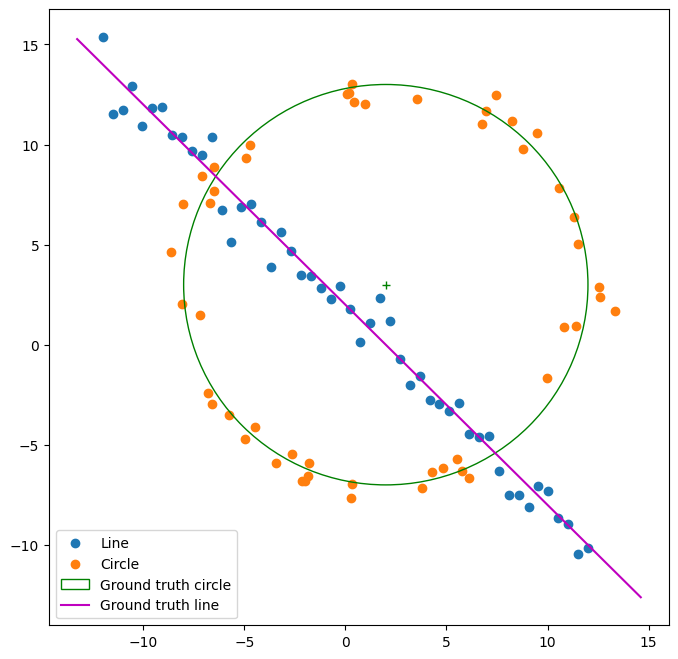

In [1181]:
# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3 # Center
s = r / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line)) # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')

ax.add_patch(circle_gt)
ax.plot([x0_gt], [y0_gt], '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])

y_ = m*x_ + b

plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()

plt.show()

The basic principle behind RANSAC is as follows:
- sample $N$ points randomly
- compute the parameters for the model using the sampled points
- count the number of inliers based on the model described by the above parameters and some specified threshold
- repeat $M$ times, so that we are at least $100\times p\%$ confident that we found at least one set of inliers
- report the parameters giving the most inliers as the best parameter estimates, if there are at least $T$ such inliers

We implement the above steps in the following function.

In [1182]:
def RANSAC(data, num_samples, params_from_samples, error_given_params, inlier_thresh, iterations, min_inlier_count = 30):
    '''
    docstring

    data is an array of tuples, each of num_samples elements
    min_inlier_count must be less than len(data)
    '''
    max_inlier_count = 0
    best_samples = None
    best_inliers = None
    best_params = None

    for _ in range(iterations):
        # Generate num_samples random integers between 0 and len(data), use these as indices to extract num_samples random samples from the data 
        sample_indices = np.random.randint(0, len(data), num_samples)
        samples = data[sample_indices]

        # Compute the model parameters using the above sampled points
        params = params_from_samples(samples)

        # Count the number of inliers based on the model described by the above parameters, and the specified threshold
        inliers = data[np.abs(error_given_params(params, data)) < inlier_thresh]
        
        # Keep track of which parameters produced the most inliers
        if ((len(inliers) > max_inlier_count)) and (len(inliers) >= min_inlier_count):
            max_inlier_count = len(inliers)
            best_samples = samples
            best_inliers = inliers
            best_params = params

    return best_samples, best_inliers, best_params

We will parameterize a straight line by $$x\cos\theta + y\sin\theta = d,$$ in terms of the parameters $\theta$ and $d$. Then, given two points $\left(x_1, y_1\right)$ and $\left(x_2, y_2\right)$ known to lie on the line, it can be shown that
$$
\theta = \arctan 2\left(x_2 - x_1, y_1 - y_2\right) \quad \text{and} \quad d = x_1 \cos\theta + y_1 \sin\theta.
$$
Further, given any point $(x, y)$, and a choice of parameters $\theta$ and $d$, we will consider the quantity $$\left|x\cos\theta + y\sin\theta - d\right|,$$ which is precisely the perpendicular distance from the point to the line, as a measure of how well the model describes $(x, y)$. If it is smaller than some threshold, we will consider the point to be an inlier, and an outlier otherwise.

Functions to compute these quantities are implemented below for a straight line.

In [1183]:
def line_params_from_samples(samples):
    '''
        for a line we expect two samples
    '''

    x1, y1 = samples[0]
    x2, y2 = samples[1]

    theta = np.atan2((x2 - x1), (y1 - y2))
    d = x1*np.cos(theta) + y1*np.sin(theta)

    return (theta, d)

def line_error(params, data):
    theta, d = params
    x, y = data[:, 0], data[:, 1]

    return x*np.cos(theta) + y*np.sin(theta) - d

We will parameterize a circle by
$$
(x-h)^2 + (y-k)^2 = r^2,
$$
where $h$, $k$, $r$ are parameters.

This time, given three points $\left(x_1, y_1\right)$, $\left(x_2, y_2\right)$ and $\left(x_3, y_3\right)$ that lie on the line, it can be shown that
$$
h = \dfrac{B_2C_1 - B_1C_2}{A_1B_2 - A_2B_1}, \quad \text{and} \quad k = \dfrac{A_2C_1 - A_1C_2}{A_2B_1 - A_1B_2},
$$
where $A_1 = 2x_2-2x_1$, $A_2 = 2x_3 - 2x_1$, $B_1 = 2y_2 - 2y_1$, $B_2 = 2y_3 - 2y_1$, $C_1 = x_2^2 - x_1^2 + y_2^2 - y_1^2$ and $C_2 = x_3^2 - x_1^2 + y_3^2 - y_1^2$. Further, for these values of $h$ and $k$, we have
$$
r = \sqrt{\left(x_1 - h\right)^2 + \left(y_1 - k\right)^2}.
$$

Given an arbitrary point $(x, y)$ and the parameters $h$, $k$ and $r$, we will consider $$\left|r - \sqrt{\left(x - h\right)^2 + \left(y - k\right)^2}\right|,$$ the "radial error", as a measure of how well the model describes the point.

We implement the code to compute these quantities in the following function.

In [1184]:
def circle_params_from_samples(samples):
    '''
        for a line we expect 3 samples
    '''

    x1, y1 = samples[0]
    x2, y2 = samples[1]
    x3, y3 = samples[2]

    A1 = 2*(x2 - x1)
    A2 = 2*(x3 - x1)
    B1 = 2*(y2 - y1)
    B2 = 2*(y3 - y1)
    C1 = x2**2 - x1**2 + y2**2 - y1**2
    C2 = x3**2 - x1**2 + y3**2 - y1**2

    h = (B2*C1 - B1*C2) / (A1*B2 - A2*B1)
    k = (A2*C1 - A1*C2) / (A2*B1 - A1*B2)
    r = np.sqrt((x1 - h)**2 + (y1 - k)**2)

    return (h, k, r)

def circle_error(params, data):
    h, k, r = params
    x, y = data[:, 0], data[:, 1]

    return r - np.sqrt((x - h)**2 + (y - k)**2)

If it is known/assumed that the fraction of inliers in the data is $r$, the probability that the $N$ points sampled are not all inliers is $1-r^N$. The probability that this is the case in all $M$ repetitions is $\left(1 - r^N\right)^M$, and hence the probability that at we pick all inliers in at least one repetition is $1 - \left(1 - r^N\right)^M$.

We would like to have
$$
1 - \left(1 - r^N\right)^M > p,
$$
or equivalently,
$$
M > \dfrac{\ln\left(1 - p\right)}{\ln\left(1 - r^N\right)}.
$$

In our case, $r=0.5$ in both cases of the line and the circle. For $p=0.99$, then, we require in the case of the line ($N=2$) that
$$
M > \dfrac{\ln 0.01}{\ln\left(1 - 0.5^2\right)} > 16,
$$
and in the case of the circle ($N=3$) that
$$
M > \dfrac{\ln 0.01}{\ln\left(1 - 0.5^3\right)} > 34,
$$
if we do not remove the points chosen for the line when sampling points for the circle.

For better results in both cases, we will set $M = 1000$.

We then run RANSAC as described to find the best parameter estimates for the line and the circle.

In [1185]:
line_best_samples, line_best_inliers, (theta_0, d_0) = RANSAC(X, 2, line_params_from_samples, line_error, 1, 1000)

remaining_points = np.array([x for x in X if x not in line_best_inliers])

circle_best_samples, circle_best_inliers, (h_0, k_0, r_0) = RANSAC(remaining_points, 3, circle_params_from_samples, circle_error, 1, 1000)

print ("RANSAC Estimates")
print()

print ("Line: ax + by = d")
print ("[with a^2 + b^2 = 1, i.e., a = cos(theta), b = sin(theta)]")
print()

print ("theta = {:0.2f} deg,".format(theta_0*180/np.pi), "d = {:0.2f}".format(d_0))
print ()

print ("{:0.2f}x + {:0.2f}y = {:0.2f}".format(np.cos(theta_0), np.sin(theta_0), d_0))

print("-" * 50)

print ("Circle: (x - h)^2 + (y - k)^2 = r^2")
print()

print ("h = {:0.2f},".format(h_0), "k = {:0.2f},".format(k_0), "r = {:0.2f}".format(r_0))
print ()

print ("(x - {:0.2f})^2 + (y - {:0.2f})^2 = {:0.2f}^2".format(h_0, k_0, r_0))

RANSAC Estimates

Line: ax + by = d
[with a^2 + b^2 = 1, i.e., a = cos(theta), b = sin(theta)]

theta = 45.48 deg, d = 1.12

0.70x + 0.71y = 1.12
--------------------------------------------------
Circle: (x - h)^2 + (y - k)^2 = r^2

h = 1.74, k = 2.85, r = 10.01

(x - 1.74)^2 + (y - 2.85)^2 = 10.01^2


C:\Users\HP\AppData\Local\Temp\ipykernel_22648\3459627657.py:17: RuntimeWarning: invalid value encountered in scalar divide
  h = (B2*C1 - B1*C2) / (A1*B2 - A2*B1)
C:\Users\HP\AppData\Local\Temp\ipykernel_22648\3459627657.py:18: RuntimeWarning: invalid value encountered in scalar divide
  k = (A2*C1 - A1*C2) / (A2*B1 - A1*B2)


We will now use regression to try and better optimize the model parameters found for the line and circle using only the found inliers. For this, we define the following objective functions to be optimized.

In [1186]:
def line_cost(params, X):
    a = params[0]
    b = params[1]
    d = params[2]

    x, y = X[:, 0], X[:, 1]

    return np.sum((x*a + y*b - d)**2)

def line_constraint(params):
    return params[0]**2 + params[1]**2 - 1

def circle_cost(params, X):
    h = params[0]
    k = params[1]
    r = params[2]

    x, y = X[:, 0], X[:, 1]

    return np.sum((r - np.sqrt((x - h)**2 + (y - k)**2))**2)

line_res = minimize(
    fun = line_cost, args = line_best_inliers,
    x0 = np.array([np.cos(theta_0), np.sin(theta_0), d_0]),
    constraints = {'type': 'eq', 'fun': line_constraint})

circle_res = minimize(
    fun = circle_cost, args = circle_best_inliers,
    x0 = np.array([h_0, k_0, r_0]))

print (line_res.x, circle_res.x)

[0.70534327 0.70886591 1.2091956 ] [1.88201413 2.82799834 9.94507726]


#### Question 03

Consider the case of capturing the image of a planar surface such as the facade of a building with a camera.

Let $o$ be the origin, which we will interpret as the position of the camera. Let $\vec{i}$, $\vec{j}$ and $\vec{k}$ be the usual unit basis vectors, with $\vec{k}$ pointing out of the page.

Without loss of generality, let the image plane be a plane parallel to the $ij$ plane, at a distance $d$ into the page; so the image plane is spanned by $\vec{i}$ and $\vec{j}$. The position vector to the origin of the image plane would be $-d \vec{k}$.

Let $O = \left(O_x, O_y, O_z\right)$ be some point on the facade, that we interpret as the origin of a coordinate plane on its plane, and let $\vec{O} = O_x\vec{i} + O_y\vec{j} + O_z\vec{k}$ be the position vector to $O$ from $o$. Further, let $\vec{X}=X_x\vec{i} + X_y\vec{j} + X_z\vec{k}$ and $\vec{Y} = Y_x\vec{i} + Y_y\vec{j} + Y_z\vec{k}$ be two basis vectors spanning the facade.

Now, let $\lambda \vec{X} + \mu \vec{Y}$ be any point on the facade, i.e., the point which has coordinates $\left(\lambda, \mu\right)$ in the facade's coordinate system. The position vector to this point from $o$ is $\vec{O} + \lambda \vec{X} + \mu \vec{Y}$.

If $\lambda' \vec{i} + \mu'\vec{j}$ is the projection of the above point on to the image plane, then we require constants $\lambda'$, $\mu'$ and $\nu'$ such that
$$
\vec{O} + \lambda \vec{X} + \mu \vec{Y} = \nu \cdot \left(-d\vec{k} + \lambda' \vec{i} + \mu'\vec{j}\right).
$$

The above requirement is found to be represented component-wise in matrix form as
$$
\begin{bmatrix}
-dX_x & -dY_x & -dO_x \\
-dX_y & -dY_y & -dO_y \\
X_z & Y_z & O_z \\
\end{bmatrix}
\begin{bmatrix}
\lambda \\
\mu \\
1
\end{bmatrix}
=
\begin{bmatrix}
\nu \lambda' \\
\nu \mu' \\
\nu
\end{bmatrix},
$$
or more compactly as
$$
\mathbf{H} \mathbf{x} = \mathbf{y},
$$
where $\mathbf{H}$ denotes the above matrix, $\mathbf{x}$, the "homogeneous" coordinates of a point on the facade, and $\mathbf{y}$, of the corresponding point on the image plane.

If some point on the facade has coordinates $\left(\lambda, \mu\right)$, and the corresponding point on the image plane has coordinates $\left(\lambda', \mu'\right)$, then, there exists a matrix $\mathbf{H}$ with entries $h_{ij}$ satisfying
$$
-h_{11}\lambda + h_{31}\lambda'\lambda - h_{12}\mu + h_{32}\lambda'\mu - h_{13} + h_{33}\lambda' = 0 \\
-h_{21}\lambda + h_{31}\mu'\lambda - h_{22}\mu + h_{32}\mu'\mu - h_{23} + h_{33}\mu' = 0
$$
which, by letting $\mathbf{h} = \begin{bmatrix} h_{11} & h_{12} & h_{13} & h_{21} & h_{22} & h_{23} & h_{31} & h_{32} & h_{33} \end{bmatrix}^\top$ is equivalent to
$$
\begin{bmatrix}
-\lambda & -\mu & -1 & 0 & 0 & 0 & \lambda'\lambda & \lambda'\mu & \lambda' \\
0 & 0 & 0 & -\lambda & -\mu & -1 & \mu'\lambda & \mu'\mu & \mu'
\end{bmatrix}
\mathbf{h} = \mathbf{0},
$$
or
$$
\mathbf{A}\mathbf{h} = \mathbf{0},
$$
denoting the matrix on the left-hand side by $\mathbf{A}$.

As seen above, a single point correspondence gives 2 equations, leaving 7 degrees of freedom. Hence, with 4 point correspondences, we are left with only one degree of freedom.

A generic solution for any number of point correspondences can be found then, by minimizing $\lVert\mathbf{A}\mathbf{h}\rVert$, subject to the constraint that $\lVert\mathbf{h}\rVert=1$, i.e.,
$$
\mathbf{h}^* = \underset{\mathbf{h}}{\arg \min}\, \lVert\mathbf{A}\mathbf{h}\rVert,
\quad
\text{subject to}
\quad
\lVert\mathbf{h}\rVert = 1,
$$
which is equivalent to
$$
\underset{\mathbf{h}}{\arg \min}\, \left(\mathbf{A}\mathbf{h}\right)^\top \left(\mathbf{A}\mathbf{h}\right) - \lambda\left(\mathbf{h}^\top\mathbf{h} - 1\right)
=
\underset{\mathbf{h}}{\arg \min}\, \mathbf{h}^\top\left(\mathbf{A}^\top\mathbf{A}\right)\mathbf{h} - \lambda\left(\mathbf{h}^\top\mathbf{h} - 1\right).
$$

Differentiating with respect to $\mathbf{h}$, we obtain
$$
\mathbf{A}^\top\mathbf{A}\mathbf{h} = \lambda\mathbf{h},
$$
so $\lambda$ is an eigenvalue of $\mathbf{A}^\top\mathbf{A}$. Multiplying both sides by $\mathbf{h}^\top$, and imposing the constraint that $\mathbf{h}^\top\mathbf{h}=\lVert\mathbf{h}\rVert=1$, we finally see that
$$
\mathbf{h}^\top\mathbf{A}^\top\mathbf{A}\mathbf{h} = \lVert\mathbf{A}\mathbf{h}\rVert = \lambda \mathbf{h}^\top\mathbf{h} = \lambda,
$$
so the minimum value of $\lVert \mathbf{A}\mathbf{h} \rVert$ is the smallest eigenvalue of $\mathbf{A}^\top\mathbf{A}$, and $\mathbf{h}^*$ is the corresponding eigenvector.

We will solve by finding the SVD of $\mathbf{A}$, which is a more numerically stable computation than eigenvalue decomposition; i.e., we look for orthonormal $\mathbf{U}$, $\mathbf{\Sigma}$ with non-negative singular values along the diagonal, and orthonormal $\mathbf{V}$ such that
$$
\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top.
$$
Then, because $\mathbf{U}^\top\mathbf{U}=\mathbf{V}^\top\mathbf{V}=\mathbf{I}$,
$$
\mathbf{A}^\top\mathbf{A} = \left(\mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top\right)^\top\mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top =
\mathbf{V}\left(\mathbf{\Sigma}^\top\mathbf{U}^\top\mathbf{U}\mathbf{\Sigma}\right)\mathbf{V}^\top
=
\mathbf{V}\left(\mathbf{\Sigma}^\top\mathbf{\Sigma}\right)\mathbf{V}^\top
=
\mathbf{V}\left(\mathbf{\Sigma}^\top\mathbf{\Sigma}\right)\mathbf{V}^{-1},
$$
which is precisely the eigendecomposition of $\mathbf{A}^\top\mathbf{A}$.

Hence, the eigenvector corresponding to the smallest eigenvalue of $\mathbf{A}^\top\mathbf{A}$ will be the last column of $\mathbf{V}$.

We now implement this in the following function.

In [1187]:
def compute_homography(correspondences):
    '''
    docstring
    4 pts expected
    '''
    # Construct the matrix A as described above
    A = np.zeros((8, 9))
    for i, (src_pt, tgt_pt) in enumerate(correspondences):
        lamda, mu = src_pt[0], src_pt[1]
        lamda_,mu_ = tgt_pt[0], tgt_pt[1]
        A[2*i] = [-lamda, -mu, -1, 0, 0, 0, lamda*lamda_, mu*lamda_, lamda_]
        A[2*i + 1] = [0, 0, 0, -lamda, -mu, -1, lamda*mu_, mu*mu_, mu_]

    # Find the SVD of A
    _, _, Vt = linalg.svd(A)

    # The last column of V (row of Vt) is the solution
    H = Vt[-1, :].reshape((3, 3))

    return H

#### Question 04

We start by loading both images.

In [1188]:
im1 = cv2.imread("graf/img1.ppm")
im2 = cv2.imread("graf/img3.ppm")

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

We then extract SIFT features from the images, find pairs of the best matching points across the images, and construct a vector of these points.

In [1189]:
# Find SIFT features from the images
sift = cv2.SIFT_create()

src_kp, src_des = sift.detectAndCompute(im1, None)
tgt_kp, tgt_des = sift.detectAndCompute(im2, None)

# Use BFMatcher to match the SIFT features across the images
bf = cv2.BFMatcher()
matches = bf.knnMatch(src_des, tgt_des, k=2)

# Pick out the best matches based on Lowe's Ratio test
matches = [m for (m, n) in matches if m.distance < 0.75*n.distance]

# Extract the coordinates of the source and target points corresponding to the best matches
src_pts = np.array([src_kp[m.queryIdx].pt for m in matches], dtype=np.float32)
tgt_pts = np.array([tgt_kp[m.trainIdx].pt for m in matches], dtype=np.float32)

# Construct a vector with source and corresponding target points
X = np.array([(src_pts[i], tgt_pts[i]) for i in range(len(src_pts))])

We can use the RANSAC algorithm implemented above to estimate the best homography matrix relating the images. For this, we first construct the relevant functions that must be passed to the `RANSAC` function we implemented above.

`compute_homography` above already computes the "model parameters" (in this case, the homography matrix) using some given samples, so we need only implement a function to compute the "error" given some model. We will use the squared 2-norm of the difference between the the point that the matrix transforms a given source point to, and the actual corresponding target point as a measure of error.

In [1190]:
def homography_error(H, data):
    src_pts, tgt_pts = data[:, 0], data[:, 1]

    src_pts_hmg = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))
    predicted_pts_hmg = H @ src_pts_hmg.T
    predicted_pts = (predicted_pts_hmg[:2, :] / predicted_pts_hmg[2, :]).T
    
    return np.linalg.norm(predicted_pts - tgt_pts, axis=1)

Now, we run `RANSAC`.

In [1191]:
# Compute a homography estimate with RANSAC
best_samples, best_inliers, H_0 = RANSAC(X, 4, compute_homography, homography_error, 200, 2000, min_inlier_count=5)

# Import the ground truth homography
H_gt = np.loadtxt("graf/H1to3p").reshape(3, 3)

H_0 /= H_0[2, 2]
print (H_0)
print ("ground truth is ")
print(H_gt)


[[ 5.27785076e-01 -2.34901207e-01  2.23810408e+02]
 [ 1.08589916e-01  8.19733395e-01  1.65017443e+01]
 [-9.53447296e-05 -3.76696873e-05  1.00000000e+00]]
ground truth is 
[[ 7.6285898e-01 -2.9922929e-01  2.2567123e+02]
 [ 3.3443473e-01  1.0143901e+00 -7.6999973e+01]
 [ 3.4663091e-04 -1.4364524e-05  1.0000000e+00]]


Next, we will define a function to stitch together two images related by some homography matrix.

In [1212]:
def stitch(im1, im2, H):
    # Find the extreme corner coordinates of both images
    w1, h1 = im1.shape[1], im1.shape[0]
    w2, h2 = im2.shape[1], im2.shape[0]

    # To transform all points on im1 to their corresponding locations in im2, we start by transforming the corners first; because the rest of the image obviously lies within these corners.
    # We choose the bottom-left corners of both images as the origins of their respective coordinate systems.
    im1_corners = np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]], dtype=np.float32).T
    im1_corners_hmg = np.vstack((im1_corners, np.ones((1, 4))))
    transformed_im1_corners_hmg = H @ im1_corners_hmg
    transformed_im1_corners = transformed_im1_corners_hmg[:2, :] / transformed_im1_corners_hmg[2, :]

    # Points in transformed_im1_corners have coordinates in im2's coordinate system. We look for the extreme corners when im1 is transformed onto im2's coordinate frame.
    leftmost_x = int(min(0, np.min(transformed_im1_corners[0, :])))
    rightmost_x = int(max(w2, np.max(transformed_im1_corners[0, :])))
    bottommost_y = int(min(0, np.min(transformed_im1_corners[1, :])))
    topmost_y = int(max(h2, np.max(transformed_im1_corners[1, :])))

    # Find the dimensions of the stitched image, im3
    w3 = rightmost_x - leftmost_x
    h3 = topmost_y - bottommost_y
    # With this transformation, if some P has coordinates (x, y) in im2, its coordinates in im3 are (x - leftmost_x, y - bottommost_y)

    # Apply the homography to im1
    im3 = cv2.warpPerspective(im1, H, (w3, h3))

    # Corners of im1 in im3's coordinate system
    im1_corners_in_im3 = np.array([
        [transformed_im1_corners[0][i] - leftmost_x, transformed_im1_corners[1][i] - bottommost_y]
        for i in range(4)
    ], dtype=np.int32)
    
    blank = np.zeros_like(im3)
    cv2.fillPoly(blank, [im1_corners_in_im3], (255, 255, 255))

    inlay = cv2.bitwise_and(im3, blank)

    blank = np.zeros_like(im3)
    blank[:h2, w3 - w2:] = im2
    cv2.fillPoly(blank, [im1_corners_in_im3], (0, 0, 0))

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(inlay, cmap='gray')

    im3[:h2, leftmost_x:] = im2

    ax[1].imshow(blank + inlay, cmap='gray')
    plt.show()

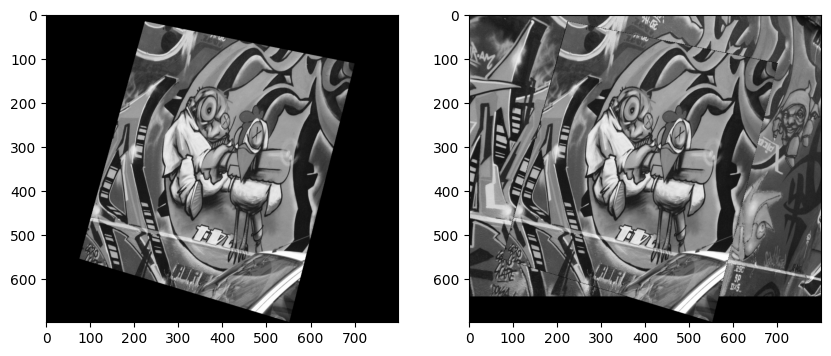

In [1216]:
stitch(im1, im2, H_0)